In [28]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    tensorflow.keras import Sequential, layers
from    PIL import Image
from    matplotlib import pyplot as plt
import  datetime

In [29]:
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

对图像进行处理，转换为tensor形式

In [30]:
# 读入图片
img = tf.io.read_file('lena.jpg')

# 解码为tensor格式
img = tf.image.decode_jpeg(img)
print('shape:', img.shape, 'dtype:', img.dtype)

# 将图片转换问灰度图片，即最后一维只有1
#img = tf.image.rgb_to_grayscale(img)
#print('shape:', img.shape, 'dtype:', img.dtype)

img = (tf.cast(img, dtype = tf.float32))/255

shape: (256, 256, 1) dtype: <dtype: 'uint8'>


构建变分自编码网络模型

编码器含有一个隐藏层，维度为64

解码器含有一个隐藏层，维度为64

隐变量z维度为16

In [31]:
h_dim = 64
z_dim = 16

In [32]:
class VAE(keras.Model):

    def __init__(self):
        super(VAE, self).__init__()

        # 编码器
        self.fc1 = layers.Dense(64)
        self.fc2 = layers.Dense(z_dim) 
        self.fc3 = layers.Dense(z_dim)

        # 解码器
        self.fc4 = layers.Dense(64)
        self.fc5 = layers.Dense(65536)


    def encoder(self, x):

        h = tf.nn.relu(self.fc1(x))
        # get mean
        mu = self.fc2(h)
        # get variance
        log_var = self.fc3(h)

        return mu, log_var

    def decoder(self, z):

        out = tf.nn.relu(self.fc4(z))
        out = self.fc5(out)

        return out

    def reparameterize(self, mu, log_var):

        eps = tf.random.normal(log_var.shape)

        std = tf.exp(log_var*0.5)

        z = mu + std * eps
        return z

    def call(self, inputs, training=None):

        # [b, 784] => [b, z_dim], [b, z_dim]
        mu, log_var = self.encoder(inputs)
        # reparameterization trick
        z = self.reparameterize(mu, log_var)

        x_hat = self.decoder(z)

        return x_hat, mu, log_var

In [33]:
lr = 1e-3 #学习率

In [34]:
model = VAE()
model.build(input_shape=(1, 65536))
optimizer = tf.optimizers.Adam(lr)

In [35]:
total_iterations=10000
y_loss=np.zeros(total_iterations) 

In [36]:
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#log_dir = 'logs/' + current_time
#summary_writer = tf.summary.create_file_writer(log_dir) 

In [37]:
for iteration in range(total_iterations):
    x = tf.reshape(img, [1,65536])
    with tf.GradientTape() as tape:
            x_rec_logits, mu, log_var = model(x)
            rec_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_rec_logits)
            rec_loss = tf.reduce_sum(rec_loss) 
            kl_div = -0.5 * (log_var + 1 - mu**2 - tf.exp(log_var))
            kl_div = tf.reduce_sum(kl_div) 
            loss = rec_loss + 1. * kl_div
            y_loss[iteration]=float(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if iteration % 1000 == 0:
            print('kl div:', float(kl_div), 'rec loss:', float(rec_loss))

kl div: 6.553609848022461 rec loss: 45427.80078125
kl div: 16487.09375 rec loss: 40630.66015625
kl div: 6367.15673828125 rec loss: 40570.5390625
kl div: 3198.0087890625 rec loss: 40557.83203125
kl div: 1762.0347900390625 rec loss: 40521.01953125
kl div: 1020.9418334960938 rec loss: 40520.0390625
kl div: 610.494140625 rec loss: 40527.9765625
kl div: 377.24908447265625 rec loss: 40515.875
kl div: 239.47335815429688 rec loss: 40516.90625
kl div: 156.6392059326172 rec loss: 40517.1796875


Text(0.5, 1.0, 'Lena')

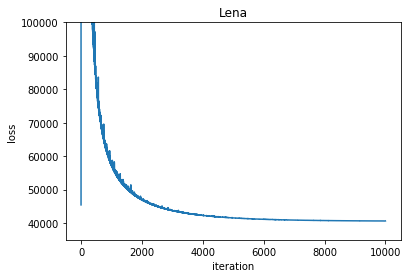

In [38]:
plt.plot(range(total_iterations), y_loss, label="First")
plt.ylim(35000, 100000)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Lena') 

In [39]:
model.save_weights('model_lena.h5')

In [40]:
model.load_weights('model_lena.h5')

In [41]:
model.summary()

Model: "vae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             multiple                  4194368   
_________________________________________________________________
dense_16 (Dense)             multiple                  1040      
_________________________________________________________________
dense_17 (Dense)             multiple                  1040      
_________________________________________________________________
dense_18 (Dense)             multiple                  1088      
_________________________________________________________________
dense_19 (Dense)             multiple                  4259840   
Total params: 8,457,376
Trainable params: 8,457,376
Non-trainable params: 0
_________________________________________________________________


通过训练后的变分自编码网络生成模型来生成图像

In [42]:
z = tf.random.normal((1, z_dim))  #构造长度为z_dim的随机向量，进行decode，可sample出原图
logits = model.decoder(z)
x_hat = tf.sigmoid(logits)
x_hat = tf.reshape(x_hat, [-1, 256, 256]).numpy() *255.
x_hat = x_hat.astype(np.uint8)

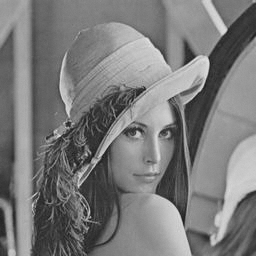

In [43]:
data = np.reshape(x_hat,(256,256))
new_im = Image.fromarray(data)
new_im

图像重构效果

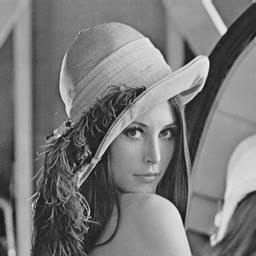

In [44]:
x = img
x = tf.reshape(x, [-1, 65536])
x_hat_logits, _, _ = model(x)
x_hat = tf.sigmoid(x_hat_logits)
x_hat = tf.reshape(x_hat, [-1, 256, 256]).numpy() *255.
x_hat = x_hat.astype(np.uint8)
data = np.reshape(x_hat,(256,256))
new_im = Image.fromarray(data)
new_im